<a href="https://colab.research.google.com/github/EdoardoMorucci/Plant-Leaves-Search-Engine---MIRCV/blob/main/Performance_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparatory operations

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# downaload the test set from https://drive.google.com/file/d/1s-tjUjvg9G32G0SoAEkDblVw_LgTK_V5/view?usp=sharing

! gdown --id 1s-tjUjvg9G32G0SoAEkDblVw_LgTK_V5 -O sets.zip

!unzip sets.zip

In [3]:
%cd "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/jupyter-notebooks"

/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/jupyter-notebooks


In [4]:
%run vpt_index.ipynb

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img
from tensorflow import keras
import sklearn 
from sklearn import preprocessing
from PIL import Image, ImageDraw, ImageOps 
import numpy as np
import pandas as pd
from IPython.display import display
import os
from os import listdir
from tqdm.auto import tqdm
import time

MODEL_PATH = '/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/model_fine_tuned'
TEST_DIR = '/content/content/healthy-unhealthy-plants-sets/test/'
FEATURES_PATH = "/content/gdrive/Shareddrives/MIRCV-PlantLeavesSearchEngine/total_features.npy"

IMAGE_SIZE = (224, 224)
BATCH_SIZE = 64
N_CLASSES = 14

In [ ]:
# create a Dataframe containing all the informations useful for retrieve and
# show the images of the leaves of TEST SET

test_dataframe = []

directories = ["Apple", "Blueberry", "Cherry", "Corn", "Grape", "Orange", "Peach", "Pepper", "Potato", "Raspberry", "Soybean", "Squash", "Strawberry", "Tomato"]
test_dataframe = pd.DataFrame(columns=['Image', 'Plant', 'Path'])
for plant in tqdm(directories):
  leaf_path = TEST_DIR + plant
  image_paths = listdir(leaf_path)
  for path in tqdm(image_paths):
    total_path = leaf_path + "/" + path
    test_dataframe = test_dataframe.append({'Image': path, 'Plant': plant, 'Path': total_path}, ignore_index=True)


# Compute *mAP*

##mAP Code

Here we compute the Average Precision that will be useful later to compute the **mean Average Precision**, that provides a compact view of the quality of
retrieval across several queries.

The formula is this:


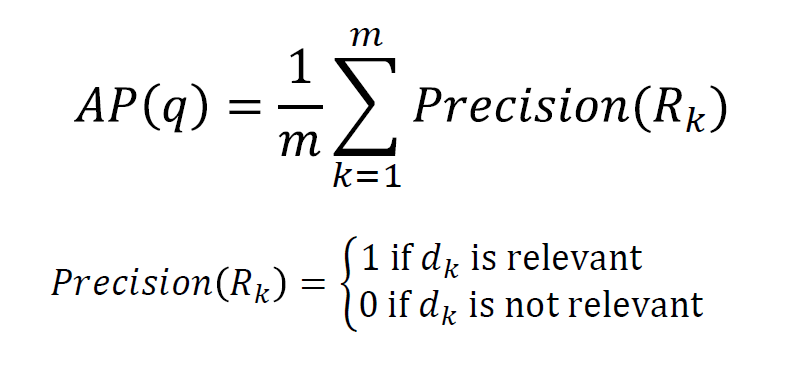

In [7]:
#compute AP@k
def compute_ap_at_k(ranked_relevance, k):
  #ranked_relevance is a boolean array of where true if relevant false is not 
  total_relevant_items = ranked_relevance.sum()

  # Precision@i for each query, i.e. the number of relevant items @i divided by i
  prec_at_i = ranked_relevance.cumsum() / np.arange(1, k + 1) 

  # sum of prec_at_i only for relevant, divide for total number of relevant items 
  aps = (ranked_relevance * prec_at_i).sum() / total_relevant_items

  return aps

In [8]:
def concat_images(kNN, dNN, relevance):
  """ It provides a grid of images retrieved using the queries with the
      distances and labels, the color of the border will be green if the 
      query is the same plant as the result, red if not. And blue for the query.
  Args:
    - set (List of Object): the set of objects resulting from the kNN query
    - dNN (List of Float): containing the distances of the results images from query
    - relevance (List of Bool): true if the result is relevant wrt query, false if is not
  Returns:
    - Doesn't return anything, it prints the grid of images.
  """
  # retrieve the paths and labels
  image_paths = []
  plants_type = []
  for obj in kNN:
    image_paths.append(test_dataframe.loc[int(obj.id), 'Path'])
    plants_type.append(test_dataframe.loc[int(obj.id), 'Plant'])

  size = [110,110]
  width, height = size
  images = []
  i = 0
  
  for path in image_paths:
    image = Image.open(path)
    image = ImageOps.fit(image, size, Image.ANTIALIAS) 
    text = ''
    if i == 0:
      color = (0,0,255)
      text += 'QUERY: \n'
    elif relevance[i]:
      color = (0,255,0)
    else:
      color = (255,0,0)
    text += plants_type[i]
    text += '\n'
    text += str(dNN[i])
    image = ImageOps.expand(image, border=3, fill=color) 
    image = ImageOps.expand(image, border=4, fill=(255,255,255))
    draw = ImageDraw.Draw(image)
    draw.text((15,15), text, (237, 230, 211))
    i += 1
    images.append(image)

  # create a new image in which paste the others
  # I have to add also the size of the border 
  image_size = (width * len(images) + 14, height + 10)
  image = Image.new('RGB', image_size)
  
  # paste images into final image
  for col in range(len(images)):
      offset = width * col, 0
      idx = col
      image.paste(images[idx], offset)
  
  display(image)
  print('\n')

We compute mAP sliding each queries and computing average precision, then we make a simple mean as shown in this formula:



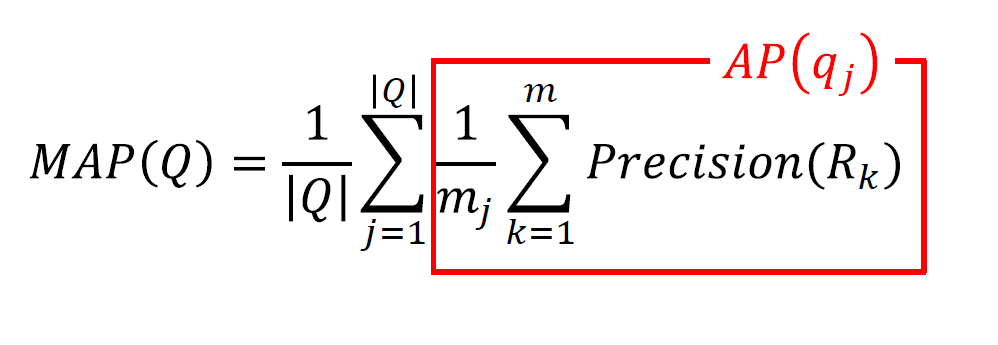

In [9]:
def evaluate_knn(queries, k, features, vp_tree, verbose=False):
  avg_prec=[]
  for query_index in queries:

    # extract the features of the queries using the index in queries
    query_features = features[query_index]
    query = Object(query_features,"Query")
    
    #perform the knn search
    kNN, dNN, distance_computations, timekNN = vp_tree.search_kNN(query, k)

    # retrieve class label of kNN and Query
    ranked_labels = [test_dataframe.loc[int(x.id), 'Plant'] for x in kNN]
    query_label = test_dataframe.loc[query_index, 'Plant'] 
    
    # relevance is if the retrieved image is relevant for the query or not
    relevance = np.array([label==query_label for label in ranked_labels])

    #compute ap@k
    ap_k = compute_ap_at_k(relevance, k) 
    avg_prec.append(ap_k)  #we store each ap_k computed
    if verbose:
      # we show no more than 10 result as images
      concat_images(kNN[:10], dNN[:10], relevance[:10])

  #calculate mAP
  mean=np.mean(avg_prec)
  if verbose:
    print('AP@', k ,'for each Query: ', avg_prec)
    print('mAP@', k ,':', mean) 
  return mean

## Model Loading, Feature Extraction and VPT creation

Loading the 2 models:
* Pretrained DenseNet
* Fine-tuned from DenseNet

And create the Test Dataset from the TEST_DIR.

In [10]:
model_finetuned = keras.models.load_model(MODEL_PATH)
# remove the last 2 classifier layers
model_finetuned = keras.models.Model(inputs=model_finetuned.input, outputs=model_finetuned.get_layer('flatten').output)

model_pretrained = tf.keras.applications.densenet.DenseNet121(
    weights='imagenet', input_tensor=None, input_shape=(224,224,3), 
    pooling='avg', include_top=False
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_DIR,
    labels='inferred', #the label of the dataset is obtained by the name of the directory
    seed=123,
    shuffle=False,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

29097984/29084464 [==============================] - 0s 0us/step
Found 7216 files belonging to 14 classes.


Extract the features of the test set with the pretrained and finetuned models.

In [11]:
finetuned_features = model_finetuned.predict(test_ds, batch_size=BATCH_SIZE, verbose=1)
pretrained_features = model_pretrained.predict(test_ds, batch_size=BATCH_SIZE, verbose=1)

113/113 [==============================] - 41s 339ms/step


Build VPT indexes using the extracted features

In [12]:
vp_tree_finetuned = VantagePointTree(features=finetuned_features, distance_measure="euclidian", size=len(finetuned_features))
vp_tree_pretrained = VantagePointTree(features=pretrained_features, distance_measure="euclidian", size=len(pretrained_features))

## Example of Query and mAP with IMAGES

FINE TUNED MODEL:


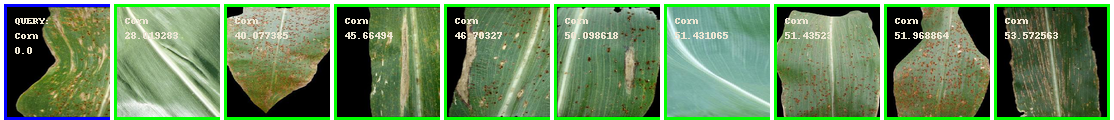

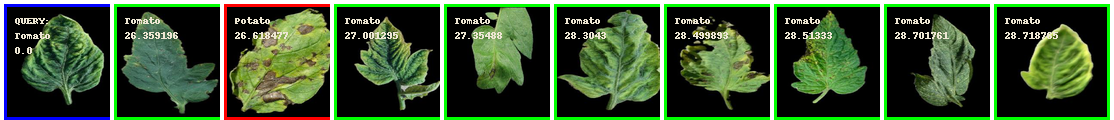

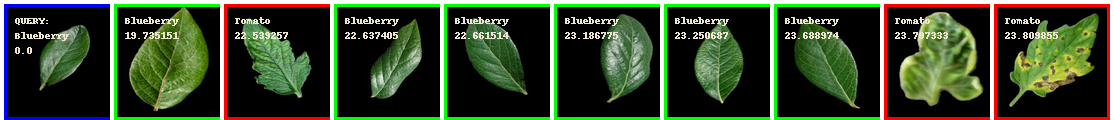

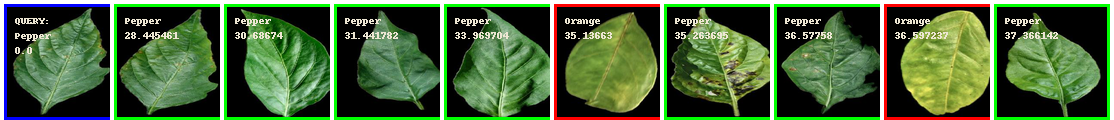

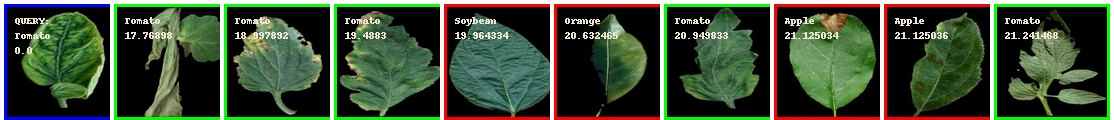



AP@ 10 for each Query:  [1.0, 0.87826278659612, 0.873639455782313, 0.9415178571428572, 0.8857142857142857]
mAP@ 10 : 0.9158268770471153
PRETRAINED MODEL


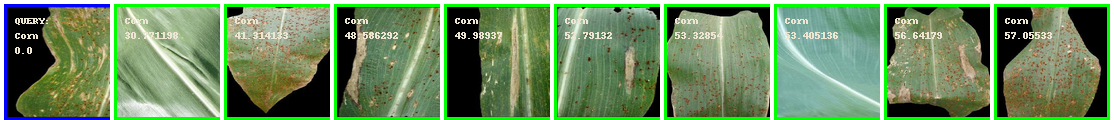

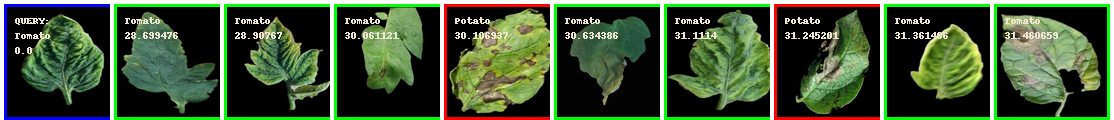

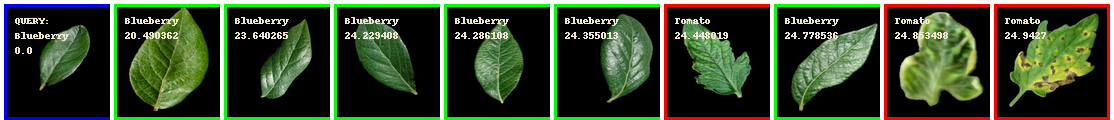

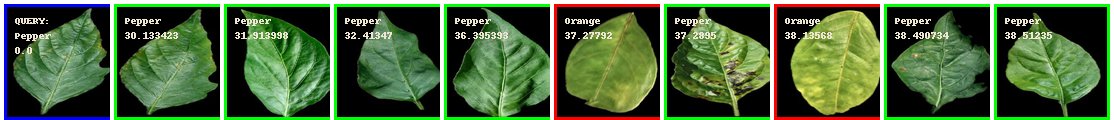

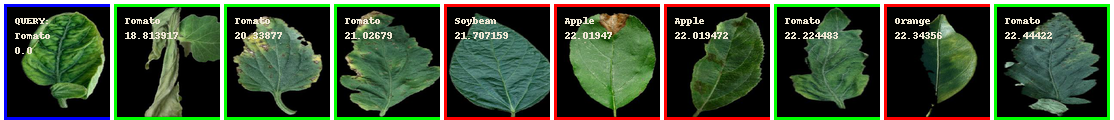



AP@ 10 for each Query:  [1.0, 0.908531746031746, 0.9821428571428571, 0.9293650793650794, 0.8708333333333332]
mAP@ 10 : 0.9381746031746033


0.9381746031746033

In [13]:
queries = [1234,6543,500,3333,7000]
k = 10

print('FINE TUNED MODEL:')
evaluate_knn(queries, k, finetuned_features, vp_tree_finetuned, verbose=True)

print('PRETRAINED MODEL')
evaluate_knn(queries, k, pretrained_features, vp_tree_pretrained, verbose=True)


# Performance evaluation
 

##Performance of MODELS

Here we compare the **Trend of mAP** using both pretrained and finetuned features and we see how the trend of the mAP, as it is intuitive, decreases as k increases, furthermore we see how the mAP values for the two features are almost similar.

This result is consistent with those seen during the fine tuning process which showed us how the initial model was already able to make a good classification and that the fine tuning only slightly increased the accuracy.

  0%|          | 0/49 [00:00<?, ?it/s]

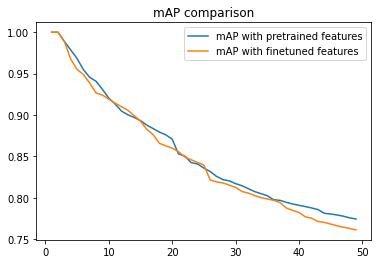

In [14]:
import scipy
import matplotlib.pyplot as plt
import random

NUM_QUERIES = 30
K = 50

queries = []
# you can set the number of queries to use
for q in range(0,NUM_QUERIES):
  queries.append(random.randint(0, 7215)) 

avg_map_for_k_ft = []
avg_map_for_k_pt = []

for k in tqdm(range(1,K)):
  avg_map_for_k_ft.append(evaluate_knn(queries, k, finetuned_features, vp_tree_finetuned))
  avg_map_for_k_pt.append(evaluate_knn(queries, k, pretrained_features, vp_tree_pretrained))

x = np.array(range(1,K))
y_ft = np.array(avg_map_for_k_ft)
y_pt = np.array(avg_map_for_k_pt)

plt.title("mAP comparison")

plt.plot(x, y_pt)
plt.plot(x, y_ft)

plt.legend(["mAP with pretrained features", "mAP with finetuned features"])


## Performance of VANTAGE POINT TREE

### Build Time

We use the features already extracted to build Vantage Point Tree using both **distance computation** available:
* **Euclidean**:  $d(x,y) = \sqrt{ \sum _{i=1} ^{n}  (x_{i} - y_{i})^{2}}$
* **Manhattan**:  $d(x,y) = \sum _{i=1} ^{n} \lvert x_{i} - y_{i} \rvert$

And using both **Pivot choice** available:
* **Random**
* **Heuristic Outlier**:
      Algorithm for an heuristic outlier
      1.   Choose a random Object
      2.   Compute distances from this object to all others
      3.   Pick the furthest object as pivot



In [ ]:
features = np.load(FEATURES_PATH)

start_time_euclidian_random = time.time()
vp_tree_euclidian_random = VantagePointTree(features, distance_measure="euclidian", size=len(features),mode_pivot_choice="Random")
time_euclidian_random = time.time() - start_time_euclidian_random

start_time_euclidian_out = time.time()
vp_tree_euclidian_out = VantagePointTree(features, distance_measure="euclidian", size=len(features),mode_pivot_choice="OutlierHeuristic")
time_euclidian_out = time.time() - start_time_euclidian_out

start_time_manhattan_random = time.time()
vp_tree_manhattan_random = VantagePointTree(features, distance_measure="manhattan", size=len(features),mode_pivot_choice="Random")
time_manhattan_random = time.time() - start_time_manhattan_random

start_time_manhattan_out = time.time()
vp_tree_manhattan_out = VantagePointTree(features, distance_measure="manhattan", size=len(features),mode_pivot_choice="OutlierHeuristic")
time_manhattan_out = time.time() - start_time_manhattan_out


print(f"Time Euclidian with Random choice for selecting Pivot: {time_euclidian_random}")
print(f"Time Euclidian with Heuristic Outlier choice for selecting Pivot: {time_euclidian_out}")
print(f"Time Manhattan with Random choice for selecting Pivot: {time_manhattan_random}")
print(f"Time Manhattan with Heuristic Outlier choice for selecting Pivot: {time_manhattan_out}")

Time Euclidian with Random choice for selecting Pivot: 22.705384969711304
Time Euclidian with Heuristic Outlier choice for selecting Pivot: 36.22830677032471
Time Manhattan with Random choice for selecting Pivot: 20.112802982330322
Time Manhattan with Heuristic Outlier choice for selecting Pivot: 32.43574333190918


As we can see the time to build the indexes is more or less the same, the reason why using **manhattan distance** is slightly faster can be the simpleness of the computation with respect to the **euclidean distance** that includes a square root.
The same reason is related to the Pivot choice that in **random** is faster than **heuristic outlier**.

### Query Time and Distance Computations

Here we take **NUM_QUERIES** queries from the dataset and we compute the **_kNN query_** for each one. We make the average of the distance computations and the query time for each query, then we make the average for each value of k used, so we can have a more robust result not depending on the single case of query.

In [ ]:
NUM_QUERIES = 20
K = 50

# create random queries from the dataset
queries = []
for q in range(0,NUM_QUERIES):
  queries.append(features[random.randint(0,97034)]) 

query_time_for_k_manh_random = np.zeros(K)
dist_comp_for_k_manh_random = np.zeros(K)
query_time_for_k_euc_random = np.zeros(K)
dist_comp_for_k_euc_random = np.zeros(K)

query_time_for_k_manh_out = np.zeros(K)
dist_comp_for_k_manh_out = np.zeros(K)
query_time_for_k_euc_out = np.zeros(K)
dist_comp_for_k_euc_out = np.zeros(K)

for k in tqdm(range(1,K)):
  sum_query_time_manh_random = 0
  sum_distance_comp_manh_random = 0
  sum_query_time_euc_random = 0
  sum_distance_comp_euc_random = 0

  sum_query_time_manh_out = 0
  sum_distance_comp_manh_out = 0
  sum_query_time_euc_out = 0
  sum_distance_comp_euc_out = 0

  for query in queries:
    query = Object(np.array(query),"Query")
    kNN, dNN, distance_computations, timekNN = vp_tree_euclidian_random.search_kNN(query, k)
    sum_query_time_euc_random += timekNN
    sum_distance_comp_euc_random += distance_computations

    kNN, dNN, distance_computations, timekNN = vp_tree_manhattan_random.search_kNN(query, k)
    sum_query_time_manh_random += timekNN
    sum_distance_comp_manh_random += distance_computations

    kNN, dNN, distance_computations, timekNN = vp_tree_euclidian_out.search_kNN(query, k)
    sum_query_time_euc_out += timekNN
    sum_distance_comp_euc_out += distance_computations

    kNN, dNN, distance_computations, timekNN = vp_tree_manhattan_out.search_kNN(query, k)
    sum_query_time_manh_out += timekNN
    sum_distance_comp_manh_out += distance_computations


  query_time_for_k_euc_random[k] = sum_query_time_euc_random/NUM_QUERIES
  # percentage of distance computed wrt to the total object in the dataset
  dist_comp_for_k_euc_random[k] = ((sum_distance_comp_euc_random/NUM_QUERIES)/97034)*100

  query_time_for_k_manh_random[k] = sum_query_time_manh_random/NUM_QUERIES
  # percentage of distance computed wrt to the total object in the dataset
  dist_comp_for_k_manh_random[k] = ((sum_distance_comp_manh_random/NUM_QUERIES)/97034)*100

  query_time_for_k_euc_out[k] = sum_query_time_euc_out/NUM_QUERIES
  # percentage of distance computed wrt to the total object in the dataset
  dist_comp_for_k_euc_out[k] = ((sum_distance_comp_euc_out/NUM_QUERIES)/97034)*100

  query_time_for_k_manh_out[k] = sum_query_time_manh_out/NUM_QUERIES
  # percentage of distance computed wrt to the total object in the dataset
  dist_comp_for_k_manh_out[k] = ((sum_distance_comp_manh_out/NUM_QUERIES)/97034)*100


  0%|          | 0/49 [00:00<?, ?it/s]

The **average query time** is very similar for almost all combinations of parameters, increasing **k** the time doesn't get bigger as well because of the index that save distance computations (as shown in the plot below).
In general we can say that using **Outlier Pivot choice** is worse in terms of average query time wrt **Random Pivot choice**, actually it is counterintuitive because the first method should provide the tree with a more accurate choice of Pivot but in this case it doesn't work.

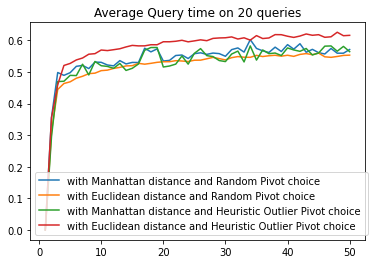

In [ ]:
import matplotlib.pyplot as plt
x = np.array(range(1,K+1))
y_manh_random = np.array(query_time_for_k_manh_random)
y_euc_random = np.array(query_time_for_k_euc_random)
y_manh_out = np.array(query_time_for_k_manh_out)
y_euc_out = np.array(query_time_for_k_euc_out)
plt.title(f"Average Query time on {NUM_QUERIES} queries")

plt.plot(x, y_manh_random)
plt.plot(x, y_euc_random)
plt.plot(x, y_manh_out)
plt.plot(x, y_euc_out)

plt.legend(["with Manhattan distance and Random Pivot choice", "with Euclidean distance and Random Pivot choice","with Manhattan distance and Heuristic Outlier Pivot choice ", "with Euclidean distance and Heuristic Outlier Pivot choice"])

The considerations made before are worth also here because of the strict link between query time and **distance computations**.
The aim of the index is accomplished, we save half of distance computations making the response of the query more or less twice faster.

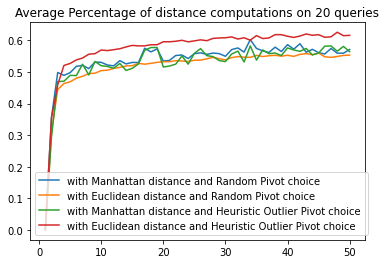

In [ ]:
import matplotlib.pyplot as plt
x = np.array(range(1,K+1))
y_manh = np.array(dist_comp_for_k_manh_random)
y_euc = np.array(dist_comp_for_k_euc_random)
y_manh = np.array(dist_comp_for_k_manh_out)
y_euc = np.array(dist_comp_for_k_euc_out)
plt.title(f"Average Percentage of distance computations on {NUM_QUERIES} queries")

plt.plot(x, y_manh_random)
plt.plot(x, y_euc_random)
plt.plot(x, y_manh_out)
plt.plot(x, y_euc_out)

plt.legend(["with Manhattan distance and Random Pivot choice", "with Euclidean distance and Random Pivot choice","with Manhattan distance and Heuristic Outlier Pivot choice ", "with Euclidean distance and Heuristic Outlier Pivot choice"])